In [1]:
# Code to mass process vertical velocity p.d.f.s from Doppler lidar data
import xarray as xr
import numpy as np
import os
import glob
import pandas as pd 
import act 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from distributed import LocalCluster, Client, wait, progress
from scipy.signal import convolve2d
from dask.diagnostics import ProgressBar

In [2]:
path = '/lcrc/group/earthscience/rjackson/wfip3/caco/pdfs/'
in_path = '/lcrc/group/earthscience/rjackson/wfip3/caco/lidar_ingested/'
window_size = (3, 3)

In [3]:
client = Client(LocalCluster(n_workers=8))
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 40,Total memory: 122.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39134,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 40
Started: Just now,Total memory: 122.80 GiB
Comm: tcp://127.0.0.1:41249,Total threads: 5
Dashboard: http://127.0.0.1:34495/status,Memory: 15.35 GiB
Nanny: tcp://127.0.0.1:46167,


In [2]:
def output_vel_product(lidar_file):
    base, name = os.path.split(lidar_file)
    ds = xr.open_dataset(lidar_file)
    if not ds.attrs["scan_type"] == "fpt":
        ds.close()
        return
    ds['radial_velocity'] = ds['radial_velocity'].where(ds['intensity'] > 1.008, drop=False)
    kernel = 1 / np.prod(window_size) * np.ones(window_size)
    vel_window_mean = convolve2d(ds['radial_velocity'], kernel, boundary='symm', mode='same')
    ds['vel_variance'] = (['time', 'range'], convolve2d(
        (ds['radial_velocity'] - vel_window_mean) ** 2, np.ones(window_size),
        boundary='symm', mode='same'))
    
    variance_bins = np.linspace(0, 2, 60)
    vel_bins = np.linspace(-10, 10, 60)
    hist_vel_variance = np.zeros((ds.sizes["range"], len(variance_bins) - 1))
    hist_vel = np.zeros((ds.sizes["range"], len(vel_bins) - 1))
    for i in range(ds.sizes["range"]):
        hist_vel_variance[i, :], bins = np.histogram(
            ds["vel_variance"].values[:, i], variance_bins)
        hist_vel[i, :], bins = np.histogram(
            ds["radial_velocity"].values[:, i], vel_bins)
    
    hist_vel_variance = xr.DataArray(hist_vel_variance, dims=('range', 'bin_vel_variance'))
    hist_vel_variance.attrs["long_name"] = "Histogram of velocity variance"
    hist_vel_variance.attrs["units"] = "counts"
    hist_vel = xr.DataArray(hist_vel, dims=('range', 'bin_vel'))
    hist_vel.attrs["long_name"] = "Histogram of velocity"
    hist_vel.attrs["units"] = "counts"
    variance_bins = xr.DataArray(variance_bins, dims=('hist_vel_variance'))
    variance_bins.attrs["long_name"] = "Velocity variance bin edges"
    variance_bins.attrs["units"] = "m-2 s-2"
    vel_bins = xr.DataArray(vel_bins, dims=('hist_vel'))
    vel_bins.attrs["long_name"] = "Velocity bin edges"
    vel_bins.attrs["units"] = "m-1 s-1"
    variance_mids = xr.DataArray(
        (variance_bins[:-1] + variance_bins[1:]) / 2.0,
        dims=('bin_vel_variance'))
    variance_mids.attrs["long_name"] = "Velocity variance bin midpoints"
    variance_mids.attrs["units"] = "m-2 s-2"
    vel_mids = xr.DataArray((vel_bins[:-1] + vel_bins[1:]) / 2.0, dims=('bin_vel'))
    vel_mids.attrs["long_name"] = "Velocity bin midpoints"
    vel_mids.attrs["units"] = "m-1 s-1"
    out_ds_data = {'hist_vel_variance': hist_vel_variance,
                   'hist_vel': hist_vel, 
                   'variance_bin_edges': variance_bins, 'vel_bin_edges': vel_bins,
                   'bin_vel_variance': variance_mids, 'bin_vel': vel_mids,
                   'range': ds['range'],
                   'time': ds['time'][0]}
    out_ds = xr.Dataset(out_ds_data)
    out_name = os.path.join(path, name[:-3] + '.freq.nc')
    out_ds.to_netcdf(out_name)
    ds.close()

In [ ]:
#pbar = ProgressBar()
#pbar.register()
file_list = sorted(glob.glob(in_path + '/**/*.nc', recursive=True))
for i in range(37000, len(file_list)):
    print(file_list[i])
    output_vel_product(file_list[i])
#results = client.map(output_vel_product, file_list)

In [ ]:
results

In [16]:
ds = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/wfip3/caco/pdfs/dl.wfip3.caco.20240314.*.r0.freq.nc',
                      concat_dim='time', combine='nested', coords='minimal', compat='override')
ds

<xarray.Dataset>
Dimensions:             (range: 400, bin_vel_variance: 59, bin_vel: 59,
                         time: 23, hist_vel_variance: 60, hist_vel: 60)
Coordinates:
  * range               (range) float64 15.0 45.0 75.0 ... 1.196e+04 1.198e+04
    hist_vel_variance   (range, bin_vel_variance) float64 dask.array<chunksize=(400, 59), meta=np.ndarray>
    hist_vel            (range, bin_vel) float64 dask.array<chunksize=(400, 59), meta=np.ndarray>
  * bin_vel_variance    (bin_vel_variance) float64 0.01695 0.05085 ... 1.983
  * bin_vel             (bin_vel) float64 -9.831 -9.492 -9.153 ... 9.492 9.831
    azimuth             float64 ...
    elevation           float64 ...
    pitch               float64 ...
    roll                float64 ...
  * time                (time) datetime64[ns] 2024-03-14T00:00:43.509996 ... ...
Data variables:
    variance_bin_edges  (time, hist_vel_variance) float64 dask.array<chunksize=(1, 60), meta=np.ndarray>
    vel_bin_edges       (time, hist_vel) float64 dask.array<chunksize=(1, 60), meta=np.ndarray>

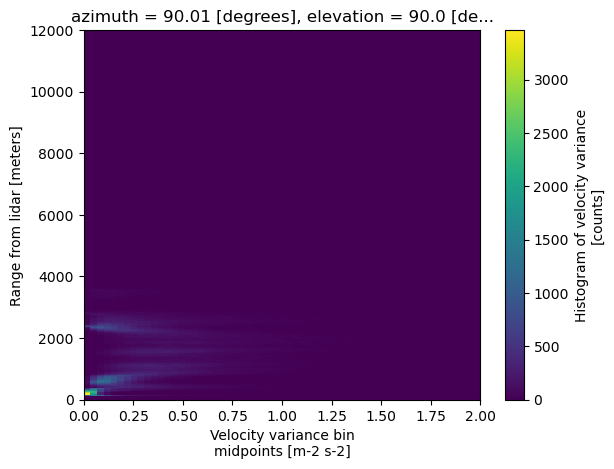

In [17]:
ds['hist_vel_variance'].plot(y='range')

In [26]:
ds.close()

In [11]:
pdf_ds = xr.open_mfdataset(
    '/lcrc/group/earthscience/rjackson/wfip3/caco/pdfs/dl.wfip3.caco.20240410.*.r0.freq.nc',  combine="nested", concat_dim="time")
pdf_ds

<xarray.Dataset>
Dimensions:             (time: 23, range: 400, bin_vel_variance: 59,
                         bin_vel: 59, hist_vel_variance: 60, hist_vel: 60)
Coordinates:
    hist_vel_variance   (time, range, bin_vel_variance) float64 dask.array<chunksize=(1, 400, 59), meta=np.ndarray>
    hist_vel            (time, range, bin_vel) float64 dask.array<chunksize=(1, 400, 59), meta=np.ndarray>
  * range               (range) float64 15.0 45.0 75.0 ... 1.196e+04 1.198e+04
  * bin_vel_variance    (bin_vel_variance) float64 0.01695 0.05085 ... 1.983
  * bin_vel             (bin_vel) float64 -9.831 -9.492 -9.153 ... 9.492 9.831
    azimuth             (time) float64 90.01 90.01 90.01 ... 90.0 90.0 90.0
    elevation           float64 90.0
    pitch               (time) float64 -0.06 -0.06 -0.17 ... -0.17 -0.06 -0.17
    roll                (time) float64 -0.14 -0.14 -0.14 ... -0.14 -0.14 -0.24
  * time                (time) datetime64[ns] 2024-04-10T00:00:43.710012 ... ...
Data variables:
    variance_bin_edges  (time, hist_vel_variance) float64 dask.array<chunksize=(1, 60), meta=np.ndarray>
    vel_bin_edges       (time, hist_vel) float64 dask.array<chunksize=(1, 60), meta=np.ndarray>

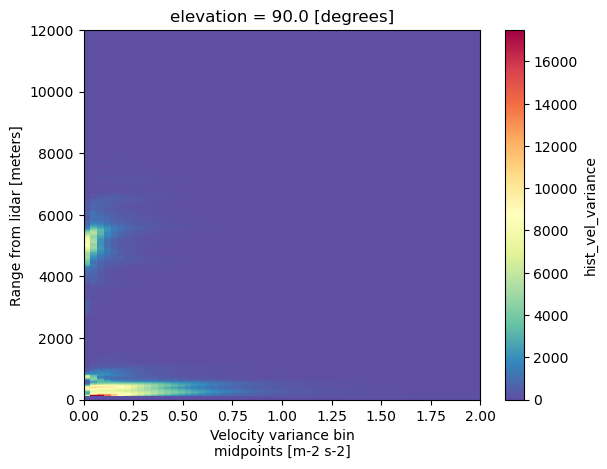

In [14]:
pdf_ds['hist_vel_variance'].sum(dim='time').plot(cmap='Spectral_r')

In [9]:
ds = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/wfip3/caco/vad/caco.lidar.vad.202403*.nc')
ds = xr.concat([ds, xr.open_mfdataset('/lcrc/group/earthscience/rjackson/wfip3/caco/vad/caco.lidar.vad.2024022*.nc')], dim='time')
ds = xr.concat([ds, xr.open_mfdataset('/lcrc/group/earthscience/rjackson/wfip3/caco/vad/caco.lidar.vad.202404*.nc')], dim='time')
ds = xr.concat([ds, xr.open_mfdataset('/lcrc/group/earthscience/rjackson/wfip3/caco/vad/caco.lidar.vad.202405*.nc')], dim='time')

In [17]:
ds

<xarray.Dataset>
Dimensions:                (time: 13175, height: 400)
Coordinates:
  * time                   (time) datetime64[ns] 2024-03-01T02:00:29.375010 ....
  * height                 (height) float64 12.99 38.97 ... 1.035e+04 1.038e+04
Data variables:
    wind_speed             (time, height) float64 dask.array<chunksize=(447, 400), meta=np.ndarray>
    wind_direction         (time, height) float64 dask.array<chunksize=(447, 400), meta=np.ndarray>
    wind_speed_error       (time, height) float64 dask.array<chunksize=(447, 400), meta=np.ndarray>
    wind_direction_error   (time, height) float64 dask.array<chunksize=(447, 400), meta=np.ndarray>
    signal_to_noise_ratio  (time, height) float64 dask.array<chunksize=(447, 400), meta=np.ndarray>
    residual               (time, height) float64 dask.array<chunksize=(447, 400), meta=np.ndarray>
    correlation            (time, height) float64 dask.array<chunksize=(447, 400), meta=np.ndarray>

In [3]:
## Get list of nocturnal turbulence events
events_list = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTnIf4gb65iX3ceZYMFKsuzIKHmjKVbMNBVsL_1K3o4qDaPJf8Rs_KQA7iQbfKX5DAFLw4aQl2Lc7iq/pub?output=csv',
                          parse_dates=True, index_col='Date')
events_list

,Nocturnal turbulence,Rain that day?,Unnamed: 3
Date,,,
2023-12-19,No,No,NaN
2023-12-20,Yes,No,Cloud deck forms around 9 UTC
2023-12-21,no data,NaN,NaN
2023-12-22,Yes,no,only under cloud detected
2023-12-23,No,No,NaN
...,...,...,...
2024-05-26,Yes,Yes,NaN
2024-05-27,No,No,Cloudy night
2024-05-28,No,No,Cloudy night


In [5]:
turb_event = np.logical_and(events_list["Nocturnal turbulence"].values == "Yes", 
                            events_list["Rain that day?"].values == "No")
turb_event = np.where(turb_event, 1, 0)
turb_event

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0])

In [6]:
events_ds = events_list.to_xarray()
events_ds

<xarray.Dataset>
Dimensions:               (Date: 117)
Coordinates:
  * Date                  (Date) datetime64[ns] 2023-12-19 ... 2024-05-30
Data variables:
    Nocturnal turbulence  (Date) object 'No' 'Yes' 'no data' ... 'No' 'No' 'Yes'
    Rain that day?        (Date) object 'No' 'No' nan 'no' ... 'No' 'No' 'Yes'
    Unnamed: 3            (Date) object nan ... 'Clouds '

In [7]:
events_ds['turb_event'] = ('Date', turb_event)
events_ds

<xarray.Dataset>
Dimensions:               (Date: 117)
Coordinates:
  * Date                  (Date) datetime64[ns] 2023-12-19 ... 2024-05-30
Data variables:
    Nocturnal turbulence  (Date) object 'No' 'Yes' 'no data' ... 'No' 'No' 'Yes'
    Rain that day?        (Date) object 'No' 'No' nan 'no' ... 'No' 'No' 'Yes'
    Unnamed: 3            (Date) object nan ... 'Clouds '
    turb_event            (Date) int64 0 1 0 0 0 0 0 0 0 0 ... 1 0 0 1 0 0 0 0 0

In [13]:
tevent = events_ds['turb_event'].reindex(Date=ds.time.values, method='nearest')

In [14]:
ds['turb_event'] = ('time', tevent.values)

/gpfs/fs1/home/rjackson/mambaforge/envs/crocus_env/lib/python3.11/site-packages/act/plotting/plot.py:81: UserWarning: Could not discern datastreamname and dict or tuple were not provided. Using defaultname of act_datastream!
  warnings.warn(


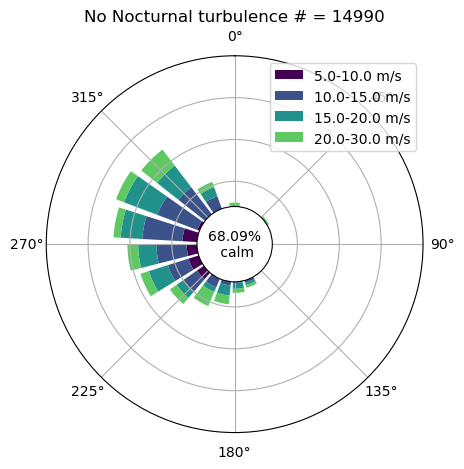

In [15]:
cluster = 0
disp = act.plotting.WindRoseDisplay(ds.where(ds.turb_event == cluster))
disp.plot("wind_direction", "wind_speed", tick_interval=10, spd_bins=[5, 10, 15, 20, 30])
plt.title("No Nocturnal turbulence # = %d" % np.sum(ds.turb_event == cluster))
disp.axes[0].set_rlim([2, 20])
disp.axes[0].set_rticks([5, 10, 15])
plt.tight_layout()
plt.savefig('wind_cluster%d.png' % (cluster+1), bbox_inches='tight')

/gpfs/fs1/home/rjackson/mambaforge/envs/crocus_env/lib/python3.11/site-packages/act/plotting/plot.py:81: UserWarning: Could not discern datastreamname and dict or tuple were not provided. Using defaultname of act_datastream!
  warnings.warn(


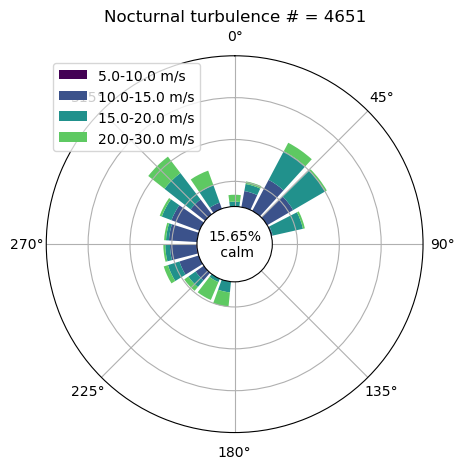

In [16]:
cluster = 1
disp = act.plotting.WindRoseDisplay(ds.where(ds.turb_event == cluster))
disp.plot("wind_direction", "wind_speed", tick_interval=10, spd_bins=[5, 10, 15, 20, 30])
plt.title("Nocturnal turbulence # = %d" % np.sum(ds.turb_event == cluster))
disp.axes[0].set_rlim([2, 20])
disp.axes[0].set_rticks([5, 10, 15])
plt.tight_layout()
plt.savefig('wind_cluster%d.png' % (cluster+1), bbox_inches='tight')

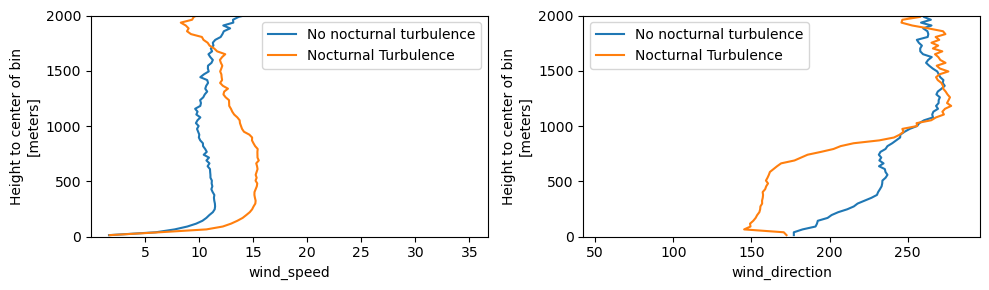

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
labels = ["No nocturnal turbulence", "Nocturnal Turbulence"]
for cluster in [0, 1]:
    vad_ds = ds.where(ds.turb_event == cluster).sortby("time")
    vad_ds = vad_ds.where(vad_ds.time.dt.hour < 10)
    vad_ds["wind_speed"].mean(dim='time').T.plot(ax=ax[0], y='height', label=labels[cluster])
    vad_ds["wind_direction"].mean(dim='time').T.plot(ax=ax[1], y='height', label=labels[cluster])
ax[0].set_ylim([0, 2000])
ax[0].legend()
ax[1].set_ylim([0, 2000])
ax[1].legend()
fig.tight_layout()

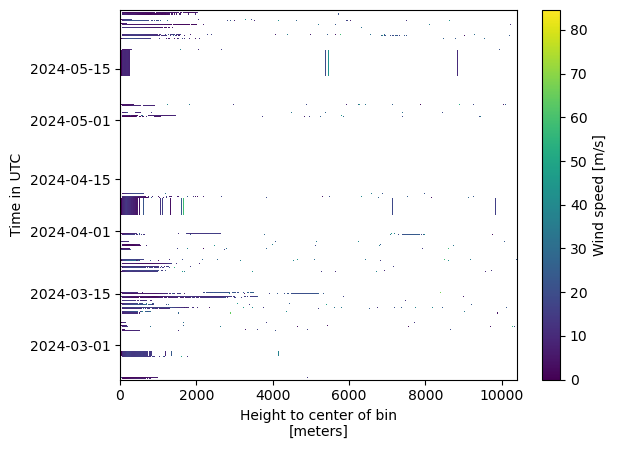

In [27]:
vad_ds.where(vad_ds.time.dt.hour < 10)["wind_speed"].plot()

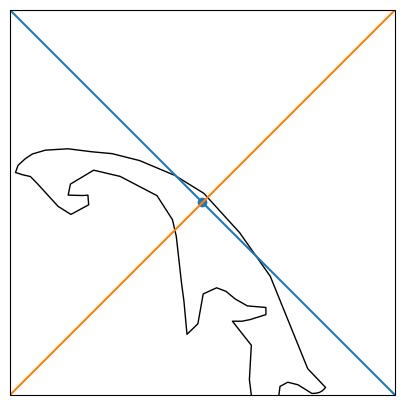

In [81]:
highlands_center = (42.03025826535351, -70.0525613525932)
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([highlands_center[1]-0.2, highlands_center[1]+0.2, highlands_center[0]-0.2, highlands_center[0]+0.2])
slope_315 = np.tan(np.deg2rad(135))
slope_45 = np.tan(np.deg2rad(45))
x = np.linspace(highlands_center[1]+0.2, highlands_center[1] - 0.2)
y_315 = highlands_center[0] + slope_315 * (x - highlands_center[1])
y_45 = highlands_center[0] + slope_45 * (x - highlands_center[1])
ax.plot(x, y_315, label='315 degrees')
ax.plot(x, y_45, label='45 degrees')
ax.coastlines(resolution='10m')
ax.scatter(highlands_center[1], highlands_center[0])